In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/drive/MyDrive/half.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [24]:
import tensorflow as tf

data_path = "/content/half"
batch_size = 32
image_size = (64, 64)

# Create TensorFlow datasets
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode="binary",  # Assuming it's a binary classification task
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    shuffle=True
)

# Split into training and testing datasets
train_size = int(0.8 * dataset.cardinality().numpy())
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Prefetch and batch the datasets
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [25]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [21]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.3 MB/s eta 0:00:00


In [26]:

import tensorflow_addons as tfa

# Vision Transformer model
def create_vit_model(image_size, num_classes):
    vit_model = tf.keras.applications.VGG16(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )

    for layer in vit_model.layers:
        layer.trainable = False

    flatten_layer = tf.keras.layers.Flatten()(vit_model.output)
    output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid')(flatten_layer)

    model = tf.keras.Model(inputs=vit_model.input, outputs=output_layer)

    return model

# Define number of classes (2 for binary classification)
num_classes = 2

# Create and compile the model
model = create_vit_model(image_size, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [27]:
epochs = 10

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)


Epoch 1/10
800/800 [==============================] - 1795s 2s/step - loss: 0.5981 - accuracy: 0.6792 - val_loss: 0.5734 - val_accuracy: 0.7030
Epoch 2/10
800/800 [==============================] - 1824s 2s/step - loss: 0.5566 - accuracy: 0.7125 - val_loss: 0.5630 - val_accuracy: 0.7081
Epoch 3/10
800/800 [==============================] - 1790s 2s/step - loss: 0.5400 - accuracy: 0.7265 - val_loss: 0.5546 - val_accuracy: 0.7175
Epoch 4/10
800/800 [==============================] - 1795s 2s/step - loss: 0.5311 - accuracy: 0.7348 - val_loss: 0.5623 - val_accuracy: 0.7127
Epoch 5/10
800/800 [==============================] - 1788s 2s/step - loss: 0.5227 - accuracy: 0.7409 - val_loss: 0.5921 - val_accuracy: 0.6969
Epoch 6/10
800/800 [==============================] - 1784s 2s/step - loss: 0.5225 - accuracy: 0.7441 - val_loss: 0.5587 - val_accuracy: 0.7147
Epoch 7/10
800/800 [==============================] - 1890s 2s/step - loss: 0.5190 - accuracy: 0.7435 - val_loss: 0.5607 - val_accuracy:

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [29]:
model.evaluate(test_dataset)


200/200 [==============================] - 368s 2s/step - loss: 0.5696 - accuracy: 0.7159


[0.5696064829826355, 0.7159374952316284]

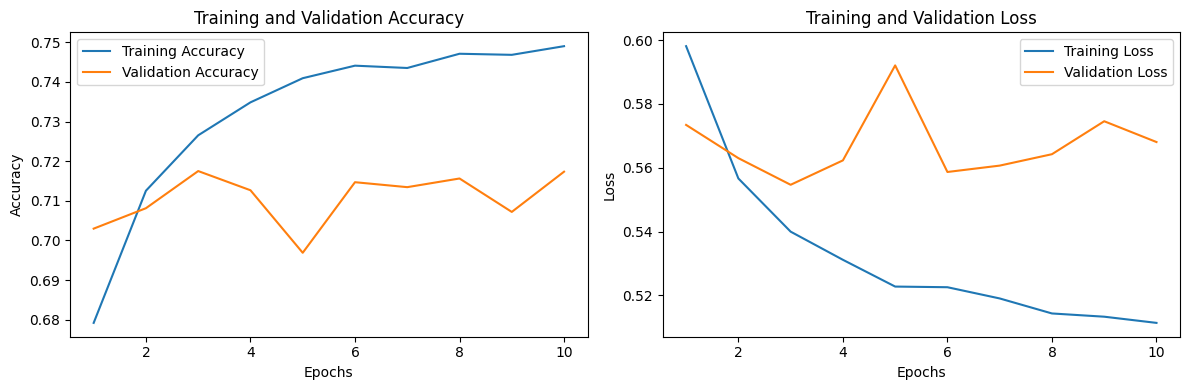

In [30]:
import matplotlib.pyplot as plt

# Get training and validation accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


200/200 [==============================] - 378s 2s/step


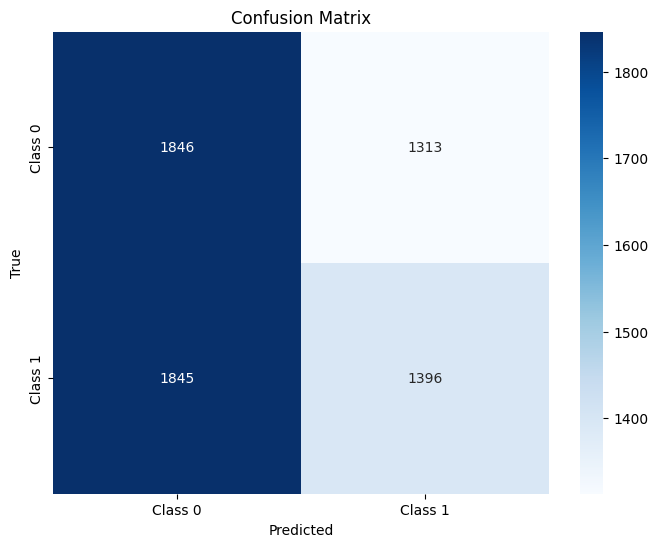

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get the predicted labels for the test dataset
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# Get the true labels for the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [32]:
from sklearn.metrics import classification_report

# Generate the classification report
class_report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.50      0.58      0.54      3159
     Class 1       0.52      0.43      0.47      3241

    accuracy                           0.51      6400
   macro avg       0.51      0.51      0.50      6400
weighted avg       0.51      0.51      0.50      6400

